In [30]:
import numpy as np
from ase.io import read
from ase import build
from scipy import ndimage
import matplotlib.pyplot as plt

from abtem import Probe, PlaneWave, Potential, PixelatedDetector, Measurement
from abtem.temperature import MDFrozenPhonons, FrozenPhonons
from abtem.measure import rotational_average
from abtem import show_atoms

In [8]:
device = 'gpu'

In [9]:
# fft cache disabled for large simulations

from cupy.fft.config import get_plan_cache
cache = get_plan_cache()
cache.set_size(1)

In [10]:
traj = read('md_phonons.traj@:')

print('Number of images:', len(traj))

Number of images: 16


In [11]:
md_fp = MDFrozenPhonons(traj)

sigma = np.mean(md_fp.standard_deviations())

print('Standard deviation:', sigma)

Standard deviation: 0.12560646637222267


In [40]:
atoms = build.bulk('Si', 'diamond', cubic=True)
atoms *= (37, 37, 240)

fp = FrozenPhonons(atoms, len(traj), {'Si': sigma}, seed=13, directions='xyz')

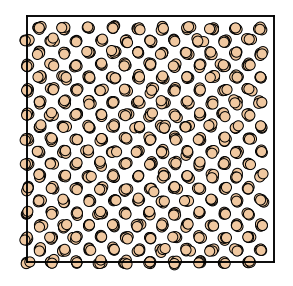

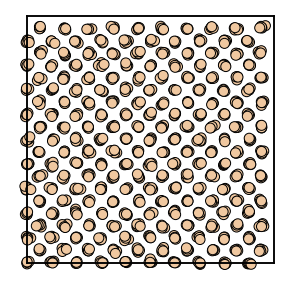

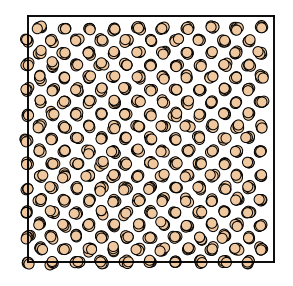

In [42]:
b = iter(fp)
for i in range(3):
    fig,ax = plt.subplots(figsize=(5,5))

    ax = show_atoms(next(b), ax=ax)

    ax.axis('off')
    plt.savefig(f'fp_{i}.png')

In [43]:
md_potential = Potential(md_fp, gpts=2048, slice_thickness=.1, 
                         device='gpu', projection='infinite', 
                         parametrization='kirkland', precalculate=False)

einstein_potential = Potential(fp, gpts=2048, slice_thickness=.1, device='gpu',
                                projection='infinite', parametrization='kirkland', precalculate=False)

elastic_potential = Potential(atoms, gpts=2048, slice_thickness=.1, device='gpu',
                              projection='infinite', parametrization='kirkland', precalculate=False)

In [21]:
probe = Probe(energy=100e3, semiangle_cutoff=9.4, device='gpu')
probe.grid.match(md_potential)

In [ ]:
measurement = probe.build().multislice(md_potential, pbar=True, max_batch_potential=1)

<module 'cupy' from 'C:\\Users\\jacob\\anaconda3\\envs\\abtem\\lib\\site-packages\\cupy\\__init__.py'>


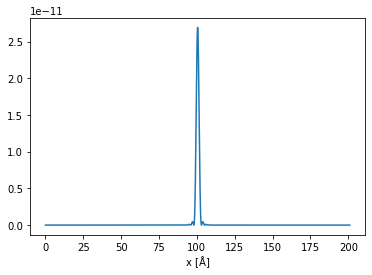

In [24]:
probe.profile().show();

In [25]:
detector = PixelatedDetector(max_angle='limit')
measurement = probe.build().multislice(md_potential, pbar=True, detector=detector, max_batch_potential=1)
measurement.write('cbed_md_si100.hdf5')

detector = PixelatedDetector(max_angle='limit')
measurement = probe.build().multislice(einstein_potential, pbar=True, detector=detector, max_batch_potential=1)
measurement.write('cbed_einstein_si100.hdf5')

KeyboardInterrupt: 

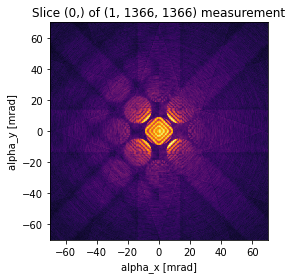

In [26]:
md_measurement = Measurement.read('cbed_md_si100.hdf5')
einstein_measurement = Measurement.read('cbed_einstein_si100.hdf5')

combined = md_measurement.copy()
combined.array[:,combined.array.shape[1]//2:] = einstein_measurement.array[:,combined.array.shape[1]//2:]

ax,_=combined.show(power=.4, cmap='inferno')

ax.set_xlim([-70,70])
ax.set_ylim([-70,70]);

In [13]:
planewave = PlaneWave(energy=100e3, device='gpu')
planewave.grid.match(md_potential)

In [ ]:
detector = PixelatedDetector(max_angle='limit')
measurement = planewave.build().multislice(md_potential, pbar=True, detector=detector, max_batch_potential=3)
measurement.write('ed_md_si100.hdf5')

detector = PixelatedDetector(max_angle='limit')
measurement = planewave.build().multislice(einstein_potential, pbar=True, detector=detector, max_batch_potential=3)
measurement.write('ed_einstein_si100.hdf5')

detector = PixelatedDetector(max_angle='limit')
measurement = planewave.build().multislice(elastic_potential, pbar=True, detector=detector, max_batch_potential=3)
measurement.write('ed_elastic_si100.hdf5')

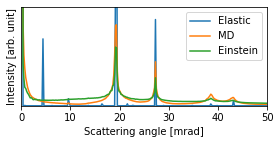

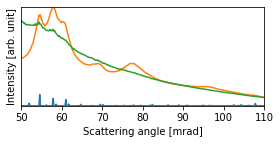

In [27]:
einstein_measurement = Measurement.read('ed_einstein_si100.hdf5')
md_measurement = Measurement.read('ed_md_si100.hdf5')
elastic_measurement = Measurement.read('ed_elastic_si100.hdf5')

fig,ax=plt.subplots(figsize=(4,2.1))

rotational_average(elastic_measurement).show(ax=ax, label='Elastic')
rotational_average(md_measurement).show(ax=ax, label='MD')
rotational_average(einstein_measurement).show(ax=ax, label='Einstein', legend=True)

ax.set_xlim([0,50])
ax.set_ylim([0,md_measurement.array.max()*1e-4])
ax.set_yticks([])
ax.set_xlabel('Scattering angle [mrad]')
ax.set_ylabel('Intensity [arb. unit]')
plt.tight_layout()

fig,ax=plt.subplots(figsize=(4,2.1))
rotational_average(elastic_measurement).show(ax=ax)
rotational_average(md_measurement).show(ax=ax)
rotational_average(einstein_measurement).show(ax=ax)

ax.set_xlim([50,110])
ax.set_ylim([0,md_measurement.array.max()*3e-6])
ax.set_yticks([])
ax.set_xlabel('Scattering angle [mrad]')
ax.set_ylabel('Intensity [arb. unit]')
plt.tight_layout()